# Paper CHF - 32 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced

import time

In [2]:
THREADS_TO_USE = 4

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_32beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,133.429003,134.242162,133.489322,37.853305,5.508392,0.586324,-0.522381,-0.788889,-0.136987,...,-0.042238,0.026644,-0.034630,0.040781,-0.065560,0.001347,-0.022417,-0.007807,-0.008983,NSR
1,e0106,133.965830,136.903950,136.743215,38.927755,5.696305,0.593533,-0.515953,-0.790798,-0.224475,...,-0.052676,0.042240,-0.050718,0.057318,-0.078975,0.010010,-0.026053,-0.011060,-0.004790,NSR
2,e0106,139.274723,140.184030,140.070259,39.704137,5.761162,0.577124,-0.518431,-0.807961,-0.219536,...,-0.051818,0.032123,-0.034994,0.042277,-0.076328,0.011880,-0.026580,-0.008271,-0.005162,NSR
3,e0106,138.676856,143.380168,143.473350,40.663806,5.859970,0.588245,-0.513443,-0.810437,-0.247007,...,-0.057101,0.036792,-0.033449,0.035388,-0.067010,0.008826,-0.025932,-0.011778,-0.000208,NSR
4,e0106,140.755171,142.872499,143.424214,40.769824,5.919625,0.585157,-0.517127,-0.798512,-0.176490,...,-0.031786,0.019955,-0.031716,0.039832,-0.068147,0.004500,-0.023807,-0.012157,-0.002940,NSR


In [5]:
data['label'].value_counts()

NSR    13090
ST-     2753
ST+     1229
Name: label, dtype: int64

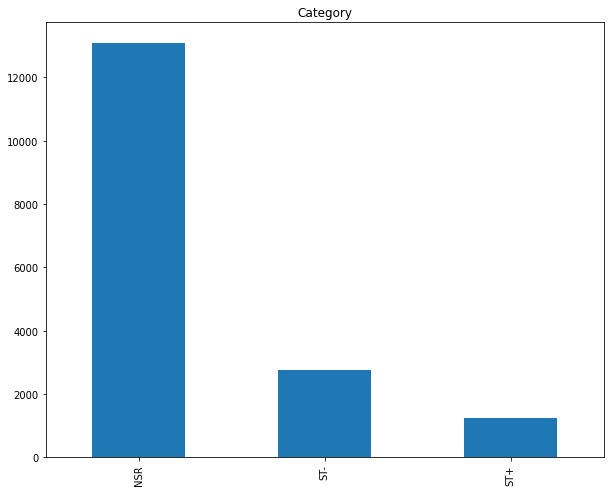

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.237685,0.106778,0.074513,0.049017,0.164754,-0.043134,0.066522,-0.005085,0.007374,...,-0.101746,-0.045780,-0.057627,-0.042941,-0.032342,-0.074357,-0.049488,-0.067248,-0.103371,-0.094220
dw_2,0.237685,1.000000,0.838142,0.502265,0.189472,0.396750,-0.511218,-0.362148,0.007304,0.027974,...,-0.110800,0.180227,0.237271,0.173162,0.054253,0.037079,0.134331,0.012952,-0.116243,-0.070422
dw_3,0.106778,0.838142,1.000000,0.702042,0.287089,0.241283,-0.555562,-0.499643,0.012774,0.016280,...,-0.199872,0.154880,0.275167,0.120954,-0.052022,0.066460,0.043879,-0.017784,-0.133008,-0.045069
dw_4,0.074513,0.502265,0.702042,1.000000,0.873295,-0.014716,-0.278260,-0.278962,0.008457,0.006416,...,-0.152384,0.071768,0.115122,0.067878,-0.039769,0.051749,0.026810,-0.031360,-0.111832,-0.044385
dw_5,0.049017,0.189472,0.287089,0.873295,1.000000,-0.124955,-0.026226,-0.049222,0.001954,0.000388,...,-0.063773,0.011881,-0.006932,0.044290,0.004779,0.016077,0.019832,-0.039655,-0.062702,-0.031614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.074357,0.037079,0.066460,0.051749,0.016077,-0.150115,0.112145,0.135231,-0.002228,0.004135,...,-0.135005,-0.212171,-0.056621,0.041745,0.071561,1.000000,0.024910,0.010580,-0.361983,-0.228896
cfr_13,-0.049488,0.134331,0.043879,0.026810,0.019832,0.073383,-0.006052,0.015178,0.006819,-0.001301,...,0.163738,0.044522,-0.209958,-0.266707,0.009957,0.024910,1.000000,0.238508,0.156749,-0.141656
cfr_14,-0.067248,0.012952,-0.017784,-0.031360,-0.039655,-0.001977,0.028472,0.029755,0.005549,-0.006743,...,0.121685,0.230485,0.039279,-0.173963,-0.282881,0.010580,0.238508,1.000000,0.221302,-0.128261
cfr_15,-0.103371,-0.116243,-0.133008,-0.111832,-0.062702,0.047377,0.081087,0.044183,0.001850,-0.014418,...,0.293341,0.157001,-0.089191,-0.138736,-0.062263,-0.361983,0.156749,0.221302,1.000000,0.344573


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()
patient_ids = data["id"].values

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_134', 'mfw_12', 'fft_133', 'fft_175', 'fft_223', 'fft_164', 'mfw_8', 'fft_182', 'fft_253', 'fft_171', 'fft_160', 'fft_168', 'mfw_15', 'fft_143', 'fft_198', 'fft_256', 'fft_153', 'fft_228', 'mfw_14', 'mfw_13', 'fft_229', 'fft_138', 'fft_232', 'fft_184', 'fft_147', 'fft_227', 'fft_231', 'fft_238', 'fft_154', 'fft_172', 'fft_144', 'fft_215', 'fft_185', 'fft_230', 'fft_200', 'fft_203', 'fft_234', 'fft_224', 'fft_169', 'fft_195', 'fft_132', 'fft_239', 'fft_199', 'fft_137', 'fft_213', 'fft_214', 'fft_165', 'fft_208', 'fft_194', 'fft_151', 'fft_176', 'fft_188', 'fft_218', 'fft_173', 'fft_210', 'fft_152', 'fft_246', 'fft_201', 'mfw_10', 'fft_150', 'fft_221', 'fft_220', 'fft_251', 'mfw_6', 'fft_197', 'fft_244', 'fft_226', 'fft_235', 'fft_242', 'fft_140', 'fft_163', 'fft_247', 'fft_233', 'fft_193', 'fft_222', 'fft_254', 'fft_236', 'fft_136', 'fft_241', 'fft_141', 'fft_148', 'fft_161', 'fft_159', 'fft_187', 'fft_240', 'fft_196', 'fft_252', 'fft_250', 'fft_202', 'fft_237', 'fft_249', 'fft_16

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_19
fft_20
fft_21
fft_22
fft_24
fft_25
fft_26
fft_28
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_11
ar_12
ar_13
ar_14
ar_15
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 74


### Visualization best features

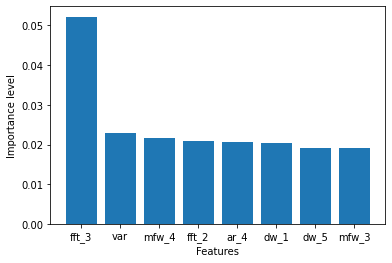

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,133.429003,134.242162,133.489322,37.853305,5.508392,0.586324,-0.522381,-0.788889,-0.136987,-1.009483,...,0.017932,0.038860,-0.042238,0.026644,-0.034630,0.040781,-0.065560,0.001347,-0.022417,-0.007807
1,133.965830,136.903950,136.743215,38.927755,5.696305,0.593533,-0.515953,-0.790798,-0.224475,2.486222,...,0.014723,0.042961,-0.052676,0.042240,-0.050718,0.057318,-0.078975,0.010010,-0.026053,-0.011060
2,139.274723,140.184030,140.070259,39.704137,5.761162,0.577124,-0.518431,-0.807961,-0.219536,-2.150671,...,0.006243,0.051369,-0.051818,0.032123,-0.034994,0.042277,-0.076328,0.011880,-0.026580,-0.008271
3,138.676856,143.380168,143.473350,40.663806,5.859970,0.588245,-0.513443,-0.810437,-0.247007,-4.289119,...,0.014157,0.055342,-0.057101,0.036792,-0.033449,0.035388,-0.067010,0.008826,-0.025932,-0.011778
4,140.755171,142.872499,143.424214,40.769824,5.919625,0.585157,-0.517127,-0.798512,-0.176490,-1.067047,...,0.034652,0.022510,-0.031786,0.019955,-0.031716,0.039832,-0.068147,0.004500,-0.023807,-0.012157


## Random Forest - L1SO

In [17]:
cvds = X_fsel.copy()
cvds["patient_id"] = patient_ids
cvds["label"] = y

patients = np.unique(cvds["patient_id"].values)
patients

array(['e0106', 'e0110', 'e0115', 'e0129', 'e0133', 'e0151', 'e0202',
       'e0203', 'e0204', 'e0205', 'e0206', 'e0207', 'e0208', 'e0210',
       'e0211', 'e0212', 'e0213', 'e0302', 'e0303', 'e0304', 'e0305',
       'e0306', 'e0403', 'e0404', 'e0405', 'e0406', 'e0408', 'e0409',
       'e0410', 'e0411', 'e0413', 'e0415', 'e0417', 'e0418', 'e0515',
       'e0601', 'e0602', 'e0603', 'e0605', 'e0606', 'e0607', 'e0609',
       'e0610', 'e0611', 'e0612', 'e0613', 'e0614', 'e0615', 'e0704',
       'e0801', 'e0808', 'e0817', 'e0818', 'e1301', 'e1302', 'e1304'],
      dtype=object)

In [18]:
classes = np.unique(label_encoder.inverse_transform(y))

In [19]:
result_df = pd.DataFrame()
tot = len(patients)
for i, patient in enumerate(patients):
    start_time = time.time()

    # Train and Test split
    df1 = cvds.loc[cvds["patient_id"] != patient]
    df2 = cvds.loc[cvds["patient_id"] == patient]

    y_train = df1["label"].values
    x_train = df1.loc[:, ~df1.columns.isin(['patient_id', 'label'])]
    y_test = df2["label"].values
    x_test = df2.loc[:, ~df2.columns.isin(['patient_id', 'label'])]

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_train, y_train)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(patients), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
1 of 56 - 3.4382574558258057 s
Tot: Accuracy 0.8133333333333334 Precision 0.8481777777777778 Recall 0.8133333333333334 Specificity 0.18666666666666668 F1 0.7296078431372549
NSR: Accuracy 0.8133333333333334 Precision 0.8133333333333334 Recall 1.0 Specificity 0.0 F1 0.8970588235294117
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
2 of 56 - 3.442162275314331 s
Tot: Accuracy 0.8054298642533937 Precision 0.8432874019778466 Recall 0.8054298642533937 Specificity 0.19457013574660634 F1 0.7186291520656847
NSR: Accuracy 0.8054298642533937 Precision 0.8054298642533937 Recall 1.0 Specificity 0.0 F1 0.8922305764411028
ST+: Accuracy 0.8054298642533937 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.8054298642533937 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
3 of 56 - 3.4001710414886475 s
Tot: Accuracy 0.9211267605633803 Precision 0.9273477484626066 Recall 0.9211267605633803 Specificity 0.07887323943661972 F1 0.8833092396018338
NSR: Accuracy 0.9211267605633803 Precision 0.9211267605633803 Recall 1.0 Specificity 0.0 F1 0.9589442815249266
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
4 of 56 - 3.560317039489746 s
Tot: Accuracy 0.8651685393258427 Precision 0.8833480621133695 Recall 0.8651685393258427 Specificity 0.1348314606741573 F1 0.8026262352781914
NSR: Accuracy 0.8651685393258427 Precision 0.8651685393258427 Recall 1.0 Specificity 0.0 F1 0.927710843373494
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
5 of 56 - 3.469712495803833 s
Tot: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
NSR: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
6 of 56 - 3.4521429538726807 s
Tot: Accuracy 0.9875 Precision 1.0 Recall 0.9875 Specificity 0.0 F1 0.9937106918238994
NSR: Accuracy 0.9875 Precision 1.0 Recall 0.9875 Specificity 0.0 F1 0.9937106918238994
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9875 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
7 of 56 - 3.5560107231140137 s
Tot: Accuracy 0.7124600638977636 Precision 0.7951392787514419 Recall 0.7124600638977636 Specificity 0.28753993610223644 F1 0.5928305755567213
NSR: Accuracy 0.7124600638977636 Precision 0.7124600638977636 Recall 1.0 Specificity 0.0 F1 0.832089552238806
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
8 of 56 - 3.415698766708374 s
Tot: Accuracy 0.7711598746081505 Precision 0.780301090453873 Recall 0.7711598746081505 Specificity 0.37275476700916627 F1 0.707946976643797
NSR: Accuracy 0.7711598746081505 Precision 0.768976897689769 Recall 0.9872881355932204 Specificity 0.1566265060240964 F1 0.8645640074211502
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8125 Recall 0.1566265060240964 Specificity 0.9872881355932204 F1 0.26262626262626265
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
9 of 56 - 3.4710752964019775 s
Tot: Accuracy 0.8839779005524862 Precision 0.9776449001129656 Recall 0.8839779005524862 Specificity 0.4067784019685223 F1 0.9262976197815139
NSR: Accuracy 0.8839779005524862 Precision 0.9906542056074766 Recall 0.8907563025210085 Specificity 0.4 F1 0.9380530973451328
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.04878048780487805 Recall 0.4 Specificity 0.8907563025210085 F1 0.08695652173913045
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
10 of 56 - 3.4432876110076904 s
Tot: Accuracy 0.6525198938992043 Precision 0.7732623180350245 Recall 0.6525198938992043 Specificity 0.34748010610079577 F1 0.5153126609926301
NSR: Accuracy 0.6525198938992043 Precision 0.6525198938992043 Recall 1.0 Specificity 0.0 F1 0.7897271268057785
ST+: Accuracy 0.6525198938992043 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.6525198938992043 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
11 of 56 - 3.3831088542938232 s
Tot: Accuracy 0.7732558139534884 Precision 0.7494998749687422 Recall 0.7732558139534884 Specificity 0.24828705683705377 F1 0.6823975222252798
NSR: Accuracy 0.7732558139534884 Precision 0.7741935483870968 Recall 0.9962264150943396 Specificity 0.02531645569620253 F1 0.8712871287128713
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.6666666666666666 Recall 0.02531645569620253 Specificity 0.9962264150943396 F1 0.048780487804878044
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
12 of 56 - 3.4398136138916016 s
Tot: Accuracy 0.7522123893805309 Precision 0.8136110893570364 Recall 0.7522123893805309 Specificity 0.24778761061946902 F1 0.6458389201752033
NSR: Accuracy 0.7522123893805309 Precision 0.7522123893805309 Recall 1.0 Specificity 0.0 F1 0.8585858585858585
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
13 of 56 - 3.47451114654541 s
Tot: Accuracy 0.9090909090909091 Precision 0.9173553719008264 Recall 0.9090909090909091 Specificity 0.09090909090909091 F1 0.8658008658008657
NSR: Accuracy 0.9090909090909091 Precision 0.9090909090909091 Recall 1.0 Specificity 0.0 F1 0.9523809523809523
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
14 of 56 - 3.402125120162964 s
Tot: Accuracy 0.8109090909090909 Precision 0.8466644628099174 Recall 0.8109090909090909 Specificity 0.1890909090909091 F1 0.7262358525009127
NSR: Accuracy 0.8109090909090909 Precision 0.8109090909090909 Recall 1.0 Specificity 0.0 F1 0.895582329317269
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
15 of 56 - 3.2527225017547607 s
Tot: Accuracy 0.8181818181818182 Precision 0.8512396694214877 Recall 0.8181818181818182 Specificity 0.18181818181818182 F1 0.7363636363636364
NSR: Accuracy 0.8181818181818182 Precision 0.8181818181818182 Recall 1.0 Specificity 0.0 F1 0.9
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
16 of 56 - 3.4470462799072266 s
Tot: Accuracy 0.9473684210526315 Precision 0.9501385041551246 Recall 0.9473684210526315 Specificity 0.05263157894736842 F1 0.9217638691322904
NSR: Accuracy 0.9473684210526315 Precision 0.9473684210526315 Recall 1.0 Specificity 0.0 F1 0.972972972972973
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
17 of 56 - 3.425483465194702 s
Tot: Accuracy 0.7443181818181818 Precision 0.790721630876498 Recall 0.7443181818181818 Specificity 0.3705096356249171 F1 0.6647017679020355
NSR: Accuracy 0.7443181818181818 Precision 0.7374631268436578 Recall 0.9960159362549801 Specificity 0.1188118811881188 F1 0.847457627118644
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.9230769230769231 Recall 0.1188118811881188 Specificity 0.9960159362549801 F1 0.2105263157894737
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
18 of 56 - 3.362081289291382 s
Tot: Accuracy 0.9692780337941628 Precision 0.9702218730017154 Recall 0.9692780337941628 Specificity 0.030721966205837174 F1 0.9541566916132868
NSR: Accuracy 0.9692780337941628 Precision 0.9692780337941628 Recall 1.0 Specificity 0.0 F1 0.984399375975039
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
19 of 56 - 3.410086154937744 s
Tot: Accuracy 0.8602150537634409 Precision 0.8797548849577986 Recall 0.8602150537634409 Specificity 0.13978494623655913 F1 0.795574616197402
NSR: Accuracy 0.8602150537634409 Precision 0.8602150537634409 Recall 1.0 Specificity 0.0 F1 0.9248554913294798
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
20 of 56 - 3.4622275829315186 s
Tot: Accuracy 0.9885496183206107 Precision 0.9886807295612143 Recall 0.9885496183206107 Specificity 0.011450381679389313 F1 0.9828573940308568
NSR: Accuracy 0.9885496183206107 Precision 0.9885496183206107 Recall 1.0 Specificity 0.0 F1 0.9942418426103647
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
21 of 56 - 3.571756601333618 s
Tot: Accuracy 0.8148148148148148 Precision 0.8492242242242242 Recall 0.8148148148148148 Specificity 0.20304232804232805 F1 0.7349544977693562
NSR: Accuracy 0.8148148148148148 Precision 0.8141891891891891 Recall 1.0 Specificity 0.017857142857142856 F1 0.8975791433891993
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.017857142857142856 Specificity 1.0 F1 0.03508771929824561
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
22 of 56 - 3.6846108436584473 s
Tot: Accuracy 0.6706827309236948 Precision 0.7791325946355704 Recall 0.6706827309236948 Specificity 0.3293172690763052 F1 0.5384808464627742
NSR: Accuracy 0.6706827309236948 Precision 0.6706827309236948 Recall 1.0 Specificity 0.0 F1 0.8028846153846154
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
23 of 56 - 3.4590108394622803 s
Tot: Accuracy 0.33676975945017185 Precision 0.7781609195402298 Recall 0.33676975945017185 Specificity 0.6683848797250859 F1 0.17393493672563437
NSR: Accuracy 0.33676975945017185 Precision 0.33448275862068966 Recall 1.0 Specificity 0.005154639175257732 F1 0.5012919896640826
ST+: Accuracy 0.33676975945017185 Precision 1.0 Recall 0.005154639175257732 Specificity 1.0 F1 0.010256410256410256
ST-: Accuracy 0.33676975945017185 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#
#---------------------#
24 of 56 - 3.2605130672454834 s
Tot: Accuracy 0.8493150684931506 Precision 0.8721251728038206 Recall 0.8493150684931506 Specificity 0.18009669621273167 F1 0.7840994670866522
NSR: Accuracy 0.8493150684931506 Precision 0.8486238532110092 Recall 1.0 Specificity 0.029411764705882353 F1 0.9181141439205955
ST+: Accuracy 0.908675799086758 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.908675799086758 precision 

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
25 of 56 - 3.1803090572357178 s
Tot: Accuracy 0.6942857142857143 Precision 0.7441399416909621 Recall 0.6942857142857143 Specificity 0.35508403361344537 F1 0.5870365495595828
NSR: Accuracy 0.6942857142857143 Precision 0.6909620991253644 Recall 0.9957983193277311 Specificity 0.05357142857142857 F1 0.8158347676419965
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8571428571428571 Recall 0.05357142857142857 Specificity 0.9957983193277311 F1 0.10084033613445377
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
26 of 56 - 3.14823579788208 s
Tot: Accuracy 0.734982332155477 Precision 0.805216696425227 Recall 0.734982332155477 Specificity 0.26501766784452296 F1 0.6227141551459846
NSR: Accuracy 0.734982332155477 Precision 0.734982332155477 Recall 1.0 Specificity 0.0 F1 0.8472505091649695
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
27 of 56 - 3.2772793769836426 s
Tot: Accuracy 0.7561837455830389 Precision 0.8372612506031973 Recall 0.7561837455830389 Specificity 0.3124146258670331 F1 0.7918559650008413
NSR: Accuracy 0.7561837455830389 Precision 0.9118942731277533 Recall 0.80859375 Specificity 0.25925925925925924 F1 0.8571428571428572
ST+: Accuracy 0.9929328621908127 Precision 0.0 Recall 1.0 Specificity 0.9929328621908127 F1 0.0
ST-: Accuracy 0.9929328621908127 precision 0.12962962962962962 Recall 0.25925925925925924 Specificity 0.81640625 F1 0.1728395061728395
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
28 of 56 - 3.34700345993042 s
Tot: Accuracy 0.05459057071960298 Precision 0.9527413743656247 Recall 0.05459057071960298 Specificity 0.9508905143538345 F1 0.01928424241645034
NSR: Accuracy 0.05707196029776675 Precision 0.04773869346733668 Recall 0.95 Specificity 0.010443864229765013 F1 0.09090909090909091
ST+: Accuracy 0.9950372208436724 Precision 0.0 Recall 1.0 Specificity 0.9950372208436724 F1 0.0
ST-: Accuracy 0.9950372208436724 precision 1.0 Recall 0.007832898172323759 Specificity 1.0 F1 0.015544041450777202
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
29 of 56 - 3.404409170150757 s
Tot: Accuracy 0.14345991561181434 Precision 0.8771208317755346 Recall 0.14345991561181434 Specificity 0.8565400843881856 F1 0.03599732199853644
NSR: Accuracy 0.14345991561181434 Precision 0.14345991561181434 Recall 1.0 Specificity 0.0 F1 0.25092250922509224
ST+: Accuracy 0.14345991561181434 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.14345991561181434 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
30 of 56 - 3.2097558975219727 s
Tot: Accuracy 0.9265175718849841 Precision 0.9319172391266625 Recall 0.9265175718849841 Specificity 0.07348242811501597 F1 0.8911777640021405
NSR: Accuracy 0.9265175718849841 Precision 0.9265175718849841 Recall 1.0 Specificity 0.0 F1 0.9618573797678276
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
31 of 56 - 3.3464674949645996 s
Tot: Accuracy 0.8984375 Precision 0.8776981441911998 Recall 0.8984375 Specificity 0.3346208858968138 F1 0.8821702860169491
NSR: Accuracy 0.8984375 Precision 0.9176954732510288 Recall 0.9737991266375546 Specificity 0.25925925925925924 F1 0.9449152542372882
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.5384615384615384 Recall 0.25925925925925924 Specificity 0.9737991266375546 F1 0.35000000000000003
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
32 of 56 - 3.389430284500122 s
Tot: Accuracy 0.5108695652173914 Precision 0.5612023451638474 Recall 0.5108695652173914 Specificity 0.5396820956812391 F1 0.43098378776713336
NSR: Accuracy 0.5108695652173914 Precision 0.4953560371517028 Recall 0.903954802259887 Specificity 0.14659685863874344 F1 0.64
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.6222222222222222 Recall 0.14659685863874344 Specificity 0.903954802259887 F1 0.23728813559322035
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
33 of 56 - 3.422632932662964 s
Tot: Accuracy 0.8477508650519031 Precision 0.8709306641443469 Recall 0.8477508650519031 Specificity 0.1522491349480969 F1 0.7778987338491247
NSR: Accuracy 0.8477508650519031 Precision 0.8477508650519031 Recall 1.0 Specificity 0.0 F1 0.9176029962546817
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
34 of 56 - 3.4973509311676025 s
Tot: Accuracy 0.7411444141689373 Precision 0.9258327881969252 Recall 0.7411444141689373 Specificity 0.7392650903811132 F1 0.8066634511669105
NSR: Accuracy 0.7411444141689373 Precision 0.9770114942528736 Recall 0.7412790697674418 Specificity 0.7391304347826086 F1 0.8429752066115703
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.16037735849056603 Recall 0.7391304347826086 Specificity 0.7412790697674418 F1 0.2635658914728682
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
35 of 56 - 3.416771411895752 s
Tot: Accuracy 0.9064327485380117 Precision 0.9454576156703816 Recall 0.9064327485380117 Specificity 0.05555555555555555 F1 0.898091342876619
NSR: Accuracy 0.9064327485380117 Precision 0.9422492401215805 Recall 0.9597523219814241 Specificity 0.0 F1 0.950920245398773
ST+: Accuracy 0.9619883040935673 Precision 0.0 Recall 1.0 Specificity 0.9619883040935673 F1 0.0
ST-: Accuracy 0.9619883040935673 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
36 of 56 - 3.4450924396514893 s
Tot: Accuracy 0.9642857142857143 Precision 1.0 Recall 0.9642857142857143 Specificity 0.0 F1 0.9818181818181819
NSR: Accuracy 0.9642857142857143 Precision 1.0 Recall 0.9642857142857143 Specificity 0.0 F1 0.9818181818181818
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9642857142857143 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
37 of 56 - 3.4831745624542236 s
Tot: Accuracy 0.8717948717948718 Precision 0.8579789666209418 Recall 0.8717948717948718 Specificity 0.33774169456025854 F1 0.8631112025495419
NSR: Accuracy 0.8717948717948718 Precision 0.9135802469135802 Recall 0.9456869009584664 Specificity 0.2631578947368421 F1 0.9293563579277865
ST+: Accuracy 0.9943019943019943 Precision 0.0 Recall 1.0 Specificity 0.9943019943019943 F1 0.0
ST-: Accuracy 0.9943019943019943 precision 0.4 Recall 0.2631578947368421 Specificity 0.952076677316294 F1 0.3174603174603174
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
38 of 56 - 3.5378613471984863 s
Tot: Accuracy 0.048 Precision 0.9543039999999999 Recall 0.048 Specificity 0.952 F1 0.0043969465648854966
NSR: Accuracy 0.048 Precision 0.048 Recall 1.0 Specificity 0.0 F1 0.0916030534351145
ST+: Accuracy 0.048 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.048 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
39 of 56 - 3.3738081455230713 s
Tot: Accuracy 0.773224043715847 Precision 0.746187726208218 Recall 0.773224043715847 Specificity 0.31230308519281696 F1 0.7043881416537903
NSR: Accuracy 0.773224043715847 Precision 0.7784090909090909 Recall 0.982078853046595 Specificity 0.10344827586206896 F1 0.8684627575277337
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.6428571428571429 Recall 0.10344827586206896 Specificity 0.982078853046595 F1 0.1782178217821782
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
40 of 56 - 3.5105183124542236 s
Tot: Accuracy 0.8327868852459016 Precision 0.8614038948179116 Recall 0.8327868852459016 Specificity 0.28790276992651215 F1 0.7750116269653041
NSR: Accuracy 0.8327868852459016 Precision 0.8288590604026845 Recall 1.0 Specificity 0.1206896551724138 F1 0.9064220183486238
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.1206896551724138 Specificity 1.0 F1 0.21538461538461542
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
41 of 56 - 3.3786892890930176 s
Tot: Accuracy 0.3611111111111111 Precision 0.7705538355693154 Recall 0.3611111111111111 Specificity 0.6436965811965812 F1 0.1953499749927037
NSR: Accuracy 0.3611111111111111 Precision 0.3591331269349845 Recall 1.0 Specificity 0.004807692307692308 F1 0.5284738041002278
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.004807692307692308 Specificity 1.0 F1 0.009569377990430623
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
42 of 56 - 3.4021263122558594 s
Tot: Accuracy 0.9389830508474576 Precision 0.923262268942302 Recall 0.9389830508474576 Specificity 0.23059580219913733 F1 0.9292447745103912
NSR: Accuracy 0.9389830508474576 Precision 0.9547038327526133 Recall 0.982078853046595 Specificity 0.1875 F1 0.9681978798586574
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.375 Recall 0.1875 Specificity 0.982078853046595 F1 0.25
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
43 of 56 - 3.487079381942749 s
Tot: Accuracy 0.8571428571428571 Precision 0.8775510204081632 Recall 0.8571428571428571 Specificity 0.14285714285714285 F1 0.7912087912087911
NSR: Accuracy 0.8571428571428571 Precision 0.8571428571428571 Recall 1.0 Specificity 0.0 F1 0.923076923076923
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
44 of 56 - 3.4314217567443848 s
Tot: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
NSR: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
45 of 56 - 3.374783992767334 s
Tot: Accuracy 0.6108597285067874 Precision 0.7622377622377622 Recall 0.6108597285067874 Specificity 0.38461538461538464 F1 0.46672428694900603
NSR: Accuracy 0.6108597285067874 Precision 0.6136363636363636 Recall 0.9926470588235294 Specificity 0.0 F1 0.7584269662921348
ST+: Accuracy 0.6153846153846154 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.6153846153846154 precision 0.0 Recall 1.0 Specificity 0.995475113122172 F1 0.0
#---------------------#
#---------------------#
46 of 56 - 3.4988017082214355 s
Tot: Accuracy 0.75 Precision 0.5836020995383545 Recall 0.75 Specificity 0.24484536082474226 F1 0.6462585034013606
NSR: Accuracy 0.75 Precision 0.7529880478087649 Recall 0.9947368421052631 Specificity 0.0 F1 0.8571428571428572
ST+: Accuracy 0.9841269841269841 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.9841269841269841 precision 0.0 Recall 0.0 Specificity 0.9948453608247423 F1 0.0
#----------------

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
47 of 56 - 3.3650174140930176 s
Tot: Accuracy 0.49299719887955185 Precision 0.5535288625254023 Recall 0.49299719887955185 Specificity 0.5680075858094434 F1 0.47308649868794345
NSR: Accuracy 0.49299719887955185 Precision 0.43529411764705883 Recall 0.75 Specificity 0.31100478468899523 F1 0.5508684863523573
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.6372549019607843 Recall 0.31100478468899523 Specificity 0.75 F1 0.4180064308681672
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
48 of 56 - 3.4353272914886475 s
Tot: Accuracy 0.9824561403508771 Precision 0.9738001391143056 Recall 0.9824561403508771 Specificity 0.01309941520467836 F1 0.9781089892873778
NSR: Accuracy 0.9824561403508771 Precision 0.986784140969163 Recall 0.9955555555555555 Specificity 0.0 F1 0.9911504424778761
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 0.0 Specificity 0.9955555555555555 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
49 of 56 - 3.4392342567443848 s
Tot: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
NSR: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 0.0 F1 1.0
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
50 of 56 - 3.374316930770874 s
Tot: Accuracy 0.9933774834437086 Precision 1.0 Recall 0.9933774834437086 Specificity 0.0 F1 0.9966777408637874
NSR: Accuracy 0.9933774834437086 Precision 1.0 Recall 0.9933774834437086 Specificity 0.0 F1 0.9966777408637874
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.0 Recall 1.0 Specificity 0.9933774834437086 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
51 of 56 - 3.367949962615967 s
Tot: Accuracy 0.11864406779661017 Precision 0.893361581920904 Recall 0.11864406779661017 Specificity 0.88204625138518 F1 0.026365348399246705
NSR: Accuracy 0.1440677966101695 Precision 0.12209302325581395 Recall 0.9767441860465116 Specificity 0.028938906752411574 F1 0.21705426356589147
ST+: Accuracy 0.12146892655367232 Precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
ST-: Accuracy 0.12146892655367232 precision 0.0 Recall 1.0 Specificity 0.9717514124293786 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\u

#---------------------#
52 of 56 - 3.420318603515625 s
Tot: Accuracy 0.967479674796748 Precision 1.0 Recall 0.967479674796748 Specificity 0.0 F1 0.9834710743801653
NSR: Accuracy 0.967479674796748 Precision 1.0 Recall 0.967479674796748 Specificity 0.0 F1 0.9834710743801653
ST+: Accuracy 0.975609756097561 Precision 0.0 Recall 1.0 Specificity 0.975609756097561 F1 0.0
ST-: Accuracy 0.975609756097561 precision 0.0 Recall 1.0 Specificity 0.991869918699187 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
53 of 56 - 3.4555721282958984 s
Tot: Accuracy 0.7337461300309598 Precision 0.7665477916682996 Recall 0.7337461300309598 Specificity 0.32787759107551995 F1 0.6400436471169336
NSR: Accuracy 0.7337461300309598 Precision 0.7310126582278481 Recall 0.9956896551724138 Specificity 0.06593406593406594 F1 0.843065693430657
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 0.8571428571428571 Recall 0.06593406593406594 Specificity 0.9956896551724138 F1 0.12244897959183673
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
54 of 56 - 3.405729293823242 s
Tot: Accuracy 0.864963503649635 Precision 0.883265153338146 Recall 0.864963503649635 Specificity 0.16135228582404917 F1 0.8058157359922665
NSR: Accuracy 0.864963503649635 Precision 0.8644688644688645 Recall 1.0 Specificity 0.02631578947368421 F1 0.9273084479371316
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.02631578947368421 Specificity 1.0 F1 0.05128205128205127
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#---------------------#
55 of 56 - 3.393965721130371 s
Tot: Accuracy 0.9053030303030303 Precision 0.9142705463728191 Recall 0.9053030303030303 Specificity 0.0946969696969697 F1 0.8603078498704742
NSR: Accuracy 0.9053030303030303 Precision 0.9053030303030303 Recall 1.0 Specificity 0.0 F1 0.9502982107355865
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#
#---------------------#
56 of 56 - 3.3932414054870605 s
Tot: Accuracy 0.7751004016064257 Precision 0.8256802309640167 Recall 0.7751004016064257 Specificity 0.2248995983935743 F1 0.6768976357920369
NSR: Accuracy 0.7751004016064257 Precision 0.7751004016064257 Recall 1.0 Specificity 0.0 F1 0.8733031674208145
ST+: Accuracy 1.0 Precision 1.0 Recall 1.0 Specificity 1.0 F1 1.0
ST-: Accuracy 1.0 precision 1.0 Recall 0.0 Specificity 1.0 F1 0.0
#---------------------#


c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.813333,0.848178,0.813333,0.186667,0.729608,0.813333,0.813333,1.000000,0.000000,0.897059,1.00000,1.0,1.0,1.0,1.0,1.00000,1.00000,0.000000,1.000000,0.000000
1,0.805430,0.843287,0.805430,0.194570,0.718629,0.805430,0.805430,1.000000,0.000000,0.892231,0.80543,1.0,0.0,1.0,0.0,0.80543,1.00000,1.000000,1.000000,1.000000
2,0.921127,0.927348,0.921127,0.078873,0.883309,0.921127,0.921127,1.000000,0.000000,0.958944,1.00000,1.0,1.0,1.0,1.0,1.00000,1.00000,0.000000,1.000000,0.000000
3,0.865169,0.883348,0.865169,0.134831,0.802626,0.865169,0.865169,1.000000,0.000000,0.927711,1.00000,1.0,1.0,1.0,1.0,1.00000,1.00000,0.000000,1.000000,0.000000
4,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000,1.0,1.0,1.0,1.0,1.00000,1.00000,1.000000,1.000000,1.000000
5,0.987500,1.000000,0.987500,0.000000,0.993711,0.987500,1.000000,0.987500,0.000000,0.993711,1.00000,1.0,1.0,1.0,1.0,1.00000,0.00000,1.000000,0.987500,0.000000
6,0.712460,0.795139,0.712460,0.287540,0.592831,0.712460,0.712460,1.000000,0.000000,0.832090,1.00000,1.0,1.0,1.0,1.0,1.00000,1.00000,0.000000,1.000000,0.000000
7,0.771160,0.780301,0.771160,0.372755,0.707947,0.771160,0.768977,0.987288,0.156627,0.864564,1.00000,1.0,1.0,1.0,1.0,1.00000,0.81250,0.156627,0.987288,0.262626
8,0.883978,0.977645,0.883978,0.406778,0.926298,0.883978,0.990654,0.890756,0.400000,0.938053,1.00000,1.0,1.0,1.0,1.0,1.00000,0.04878,0.400000,0.890756,0.086957
9,0.652520,0.773262,0.652520,0.347480,0.515313,0.652520,0.652520,1.000000,0.000000,0.789727,0.65252,1.0,0.0,1.0,0.0,0.65252,1.00000,1.000000,1.000000,1.000000


In [21]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_32beats_l1so.csv')

######## Total ########
Accuracy 0.7627597994840218
Precision 0.8632516848482121
Recall 0.7627597994840218
Specificity 0.27494048000244364
F1 0.7074927219584316
######## NSR ########
Accuracy 0.7632581051695883
Precision 0.7737006599717796
Recall 0.9773450885128337
Specificity 0.05952208141635605
F1 0.8336112788377197
######## ST+ ########
Accuracy 0.9202804624266826
Precision 0.9107142857142857
Recall 0.8393777614138439
Specificity 0.9985691095987074
F1 0.7501831501831502
######## ST- ########
Accuracy 0.9202804624266826
Precision 0.7441270104545726
Recall 0.30961694382238425
Specificity 0.979609088471402
F1 0.204995681174555
